# Identifying Art styles with Convnet

This notebook runs on a part of the https://www.kaggle.com/c/painter-by-numbers dataset containing only 4 of the Art styles (Abstract Expressionism, Cubism, Early Renaissance, Ukiyo-e). I shared the dataset as well for those interested in running the same analysis. 

I wanted to create a Convnet that was indentifying art styles. There is many art style in the original dataset, some with more than 8000 images in them. For RAM/time analysis reasons I used art that were:
* very different (Cubism/Renaissance) instead of going with very similar art styles (Early VS late renaissance); 
* I also chose those because they had enough data to create an accurate CNN but not so many that the analysis were taking too long (around ~1000 images each in the train set). 

I took the VGG16 pretrained model to identify the images and add a few layers of hidden neurons. 

I also display 10 random images taken of the testset and plot them with they prediction and proability after.


In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

i = 224 # change input to test different models

# create image generator
train_generator = ImageDataGenerator(rescale=1/255, horizontal_flip=True,
                                    rotation_range=5, 
                                    validation_split=0.2)

test_generator = ImageDataGenerator(rescale=1/255)

batch_size = 200
# Train, validation and test sets
trainset = train_generator.flow_from_directory(os.path.join('../input/subset-train/subset_train/subset_train'),
                                              batch_size=batch_size, 
                                              target_size=(i,i),
                                              shuffle=True, subset='training')

validset = train_generator.flow_from_directory(os.path.join('../input/subset-train/subset_train/subset_train'),
                                              batch_size=batch_size, 
                                              target_size=(i,i),
                                              shuffle=False, subset='validation')

testset = test_generator.flow_from_directory(os.path.join('../input/subset-train/subset_test/subset_test'),
                                              batch_size=batch_size, 
                                              target_size=(i,i),
                                              shuffle=False)

Found 4042 images belonging to 4 classes.
Found 1009 images belonging to 4 classes.
Found 1547 images belonging to 4 classes.


In [2]:
from tensorflow.keras.applications import vgg16 

i=224

# load model
model = vgg16.VGG16(weights='imagenet', 
                    include_top=False, 
                    pooling='avg', 
                    input_shape=(i,i, 3))

for layer in model.layers:
    layer.trainable = False
    
# summarize the model
model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [3]:
def layer_adder(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dropout(0.25)(top_model)
    top_model = Dense(256, activation='relu')(top_model)
    top_model = Dense(128, activation='relu')(top_model)
    top_model = Dense(num_classes, activation='softmax')(top_model)
    return top_model

In [4]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential

# set class number
num_classes = 4

FC_Head = layer_adder(model, num_classes)

model = Model(inputs=model.input, outputs=FC_Head)

print(model.summary)

<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x7fd08b299f10>>


In [5]:
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['acc'])

In [6]:
# train model
import PIL.Image
PIL.Image.MAX_IMAGE_PIXELS = None
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

epoch = 50
early_stopping = [EarlyStopping(patience=3, monitor='val_loss'), ReduceLROnPlateau(patience=2), 
                  ModelCheckpoint(filepath='ART_CNN.h5', save_best_only=True)]

history = model.fit_generator(
    generator=trainset, validation_data=validset, epochs=epoch, callbacks=early_stopping)

Epoch 1/50
21/21 [==============================] - 220s 10s/step - loss: 1.0968 - acc: 0.5520 - val_loss: 0.7349 - val_acc: 0.7255
Epoch 2/50
21/21 [==============================] - 195s 9s/step - loss: 0.7057 - acc: 0.7368 - val_loss: 0.6488 - val_acc: 0.7572
Epoch 3/50
21/21 [==============================] - 199s 9s/step - loss: 0.5949 - acc: 0.7731 - val_loss: 0.5892 - val_acc: 0.7849
Epoch 4/50
21/21 [==============================] - 191s 9s/step - loss: 0.5229 - acc: 0.8016 - val_loss: 0.5110 - val_acc: 0.8127
Epoch 5/50
21/21 [==============================] - 190s 9s/step - loss: 0.4742 - acc: 0.8224 - val_loss: 0.4763 - val_acc: 0.8226
Epoch 6/50
21/21 [==============================] - 190s 9s/step - loss: 0.4634 - acc: 0.8248 - val_loss: 0.4679 - val_acc: 0.8216
Epoch 7/50
21/21 [==============================] - 189s 9s/step - loss: 0.4193 - acc: 0.8375 - val_loss: 0.4908 - val_acc: 0.8236
Epoch 8/50
21/21 [==============================] - 188s 9s/step - loss: 0.4246 - 

In [7]:
model.save('ART_CNN_final.h5') # Saves architecture and weights
print('Model Saved')

Model Saved


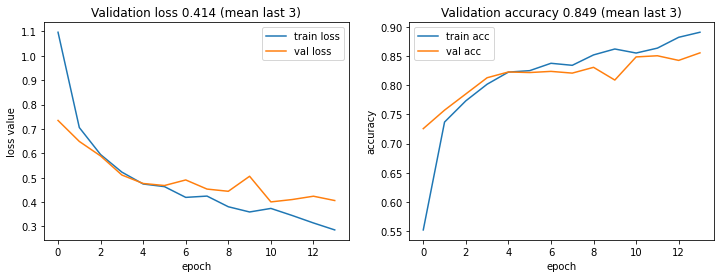

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot accuracy values
ax1.plot(history.history['loss'], label='train loss')
ax1.plot(history.history['val_loss'], label='val loss')
ax1.set_title('Validation loss {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_loss'][-3:]) # last three values
))
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss value')
ax1.legend()

# Plot accuracy values
ax2.plot(history.history['acc'], label='train acc')
ax2.plot(history.history['val_acc'], label='val acc')
ax2.set_title('Validation accuracy {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_acc'][-3:]) # last three values
))
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()
plt.show()

In [9]:
style_list = ['Abstract Expressionism','Cubism','Early Renaissance', 'Ukiyo-e']

In [10]:
test_loss, test_acurracy = model.evaluate(testset)
print('Test loss: {:.2f}, accuracy: {:.2f}%'.format(test_loss, test_acurracy*100))

8/8 [==============================] - 40s 5s/step - loss: 0.4514 - acc: 0.8281
Test loss: 0.45, accuracy: 82.81%


In [11]:
Y_pred = model.predict_generator(testset)
y_pred = np.argmax(Y_pred, axis=1)

In [12]:
from sklearn.metrics import classification_report

print(classification_report(testset.classes, y_pred, target_names = style_list))

                        precision    recall  f1-score   support

Abstract Expressionism       0.87      0.81      0.84       528
                Cubism       0.81      0.82      0.81       431
     Early Renaissance       0.81      0.82      0.82       299
               Ukiyo-e       0.80      0.88      0.84       289

              accuracy                           0.83      1547
             macro avg       0.82      0.83      0.83      1547
          weighted avg       0.83      0.83      0.83      1547



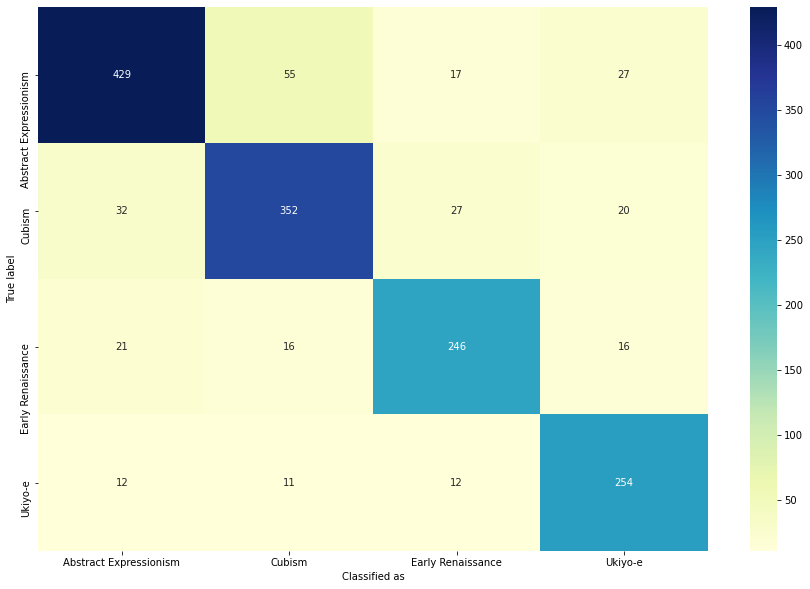

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix = confusion_matrix(y_true=testset.classes, y_pred=y_pred)

plt.figure(figsize = (15,10))
ax = sns.heatmap(matrix,cmap="YlGnBu", linecolor = 'black' , linewidth = 0, annot = True, fmt='', xticklabels=style_list,
                 yticklabels=style_list);
ax.set(xlabel='Classified as', ylabel='True label')
plt.show()

../input/subset-train/subset_test/subset_test/Cubism/46949.jpg
../input/subset-train/subset_test/subset_test/Abstract Expressionism/36228.jpg
../input/subset-train/subset_test/subset_test/Early Renaissance/53244.jpg
../input/subset-train/subset_test/subset_test/Abstract Expressionism/92568.jpg
../input/subset-train/subset_test/subset_test/Cubism/61707.jpg
../input/subset-train/subset_test/subset_test/Cubism/7333.jpg
../input/subset-train/subset_test/subset_test/Cubism/13237.jpg
../input/subset-train/subset_test/subset_test/Cubism/41507.jpg
../input/subset-train/subset_test/subset_test/Cubism/95475.jpg
../input/subset-train/subset_test/subset_test/Cubism/100532.jpg


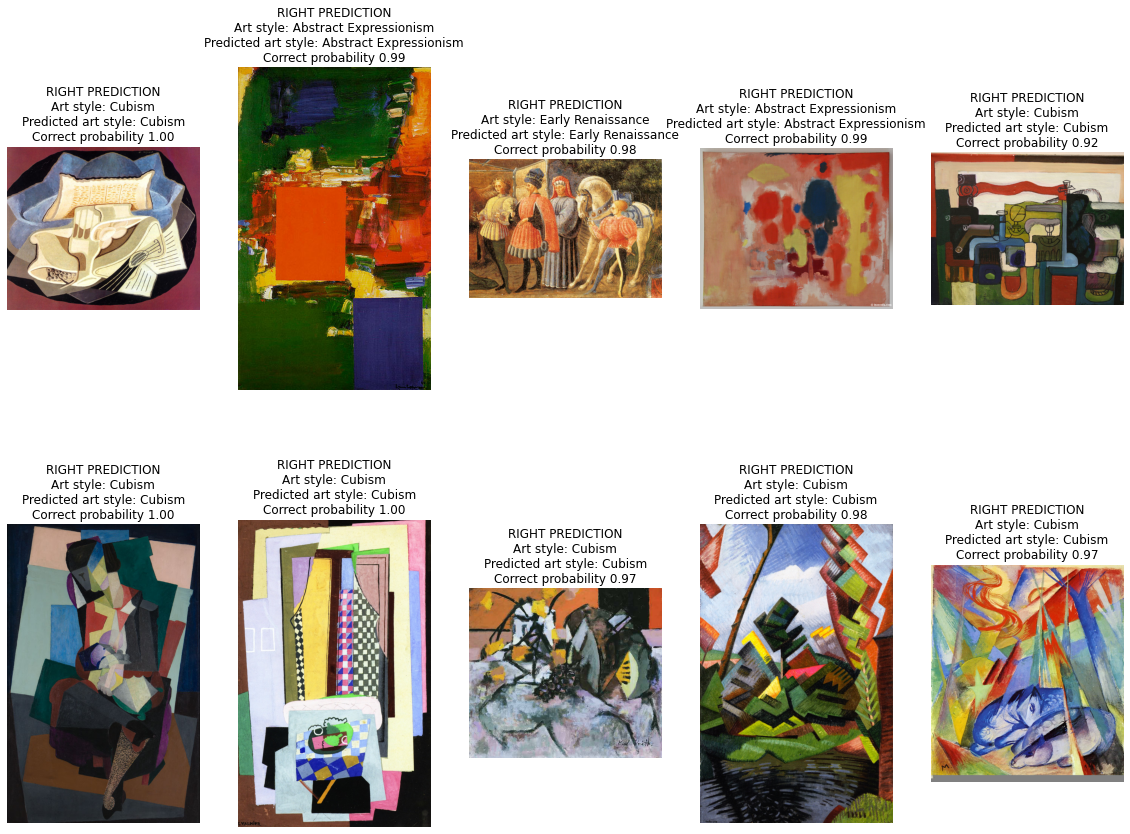

In [14]:
import random
from PIL import Image

list_style = ['Abstract Expressionism','Cubism','Early Renaissance', 'Ukiyo-e']
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 15))

for num, axis in zip(range(0,10), axes.flatten()):
    
    seed = random.randint(0,1547)
    
    # get target 
    target = testset.classes[seed]
    style_true = list_style[target]
    
#     print(target)
    
    # Get predictions
    predictions = Y_pred[seed]
    y_pred_plot = np.argmax(predictions)
    probability = predictions.max()
#     print(predictions)
#     print(y_pred_plot)
#     print(probability)
    style_pred = list_style[y_pred_plot]
    
    outcome = ''
    if style_true == style_pred:
        outcome = 'RIGHT PREDICTION'
    else:
        outcome = 'WRONG PREDICTION'

    print(testset.filepaths[seed])
    # Load image
    img = Image.open(str(testset.filepaths[seed]))
    
    img = np.array(img)
    axis.imshow(img);
    axis.set_title(f'{outcome}\nArt style: {style_true}\nPredicted art style: {style_pred}\nCorrect probability {probability:.2f}')
    axis.axis('off') # hide axis
    
    
plt.show()